In [197]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings

In [2]:
house_df = pd.read_csv('data/house_mean_imputation.csv')
#house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])

display(house_df.shape)
display(house_df.head())

(9974, 20)

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281,1,1824,1824.0,0,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202,1,1826,1824.0,1,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272,1,1828,1824.0,2,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
3,District 1,0.0,John Law,D,49.1,Indiana,10868,0,1830,1860.0,0,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280,1,1830,1824.0,3,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375


In [145]:
display(house_df.loc[(house_df['year']==2018)][['last_D_house_seats', 'last_R_house_seats']].iloc[0])

last_D_house_seats    194.0
last_R_house_seats    241.0
Name: 9130, dtype: float64

In [4]:
#house_df2=house_df.set_index(['year', 'state', 'district', 'name']).dropna().copy()
#house_df2=house_df.dropna().copy()
#house_df2_districts=house_df2[['state','district']]
#house_df2=house_df2.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1)
#house_df2['party']=house_df2['party'].replace(['D', 'R'], [0, 1])
#house_df2['president_party']=house_df2['president_party'].replace(['D', 'R'], [0, 1])
#house_df2['last_house_majority']=house_df2['last_house_majority'].replace(['D', 'R'], [0, 1])
#data_train, data_test=house_df2[house_df2['year']!=2018], house_df2[house_df2['year']==2018]

#x_train, y_train=data_train.drop('won', axis=1).drop('percent', axis=1).drop('votes', axis=1), data_train['won']
#x_test, y_test=data_test.drop('won', axis=1).drop('percent', axis=1).drop('votes', axis=1), data_test['won']
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts

In [198]:
def modelPredictions(model, x_train, x_test, y_train, y_test, indexed_districts):
    def Accuracy(y, y_pred):
        return np.sum(y == y_pred) / len(y)

    #troubleshooting 1998 data
    #display(x_train.head())
    #display(x_test.head())
    #predict results
    y_pred_train=model.predict(x_train)
    y_pred_test=model.predict(x_test)

    #calculate accuracy
    Accu_train=Accuracy(y_train, y_pred_train)
    Accu_val=Accuracy(y_test, y_pred_test)
    
    #At this stage, our predictions could lead to more than one winner per district (or none), but in reality they are mutually exclusive 
    #We will take the maximum prediction probabilities to be sure to have one and only one winner per district
    #predict probabilities
    y_pred_train=model.predict_proba(x_train)[:,1]
    y_pred_test=model.predict_proba(x_test)[:,1]

    #Add index to predictions from X set
    y_pred_train_df=pd.DataFrame(y_pred_train, index=x_train.index, columns=['abs_won_proba'])
    y_pred_test_df=pd.DataFrame(y_pred_test, index=x_test.index, columns=['abs_won_proba'])

    #Join district data, party and predictions by index
    districts_pred_train=indexed_districts.join(x_train[['party']]).join(y_pred_train_df).dropna()
    districts_pred_test=indexed_districts.join(x_test[['party']]).join(y_pred_test_df).dropna()

    #Group by district and aggregate predictions with max probability
    districts_pred_test_grouped=districts_pred_test.groupby(['state', 'district']).agg({'abs_won_proba':('max', 'sum')})
    districts_pred_test_grouped.columns = ['max_won_proba', 'sum_won_proba']
    districts_pred_test_grouped = districts_pred_test_grouped.reset_index(drop=False)

    #Create won_pred response variable (at this stage we have only the winner candidates)
    districts_pred_test_grouped['won_pred']=1

    #join district and party data with max predictions probabilities 
    out_df=districts_pred_test.join(districts_pred_test_grouped.set_index(['state', 'district', 'max_won_proba'])['won_pred'],on=['state', 'district', 'abs_won_proba']).fillna(0)

    #join district and party data with sum predictions probabilities 
    out_df=out_df.join(districts_pred_test_grouped.set_index(['state', 'district'])['sum_won_proba'],on=['state', 'district'])
    
    #calculate relative probability. That takes into account the predictions of the other candidates within the same district
    out_df['rel_won_proba']=out_df['abs_won_proba']/out_df['sum_won_proba']
    #display(out_df[(out_df['state']=='Louisiana')&(out_df['district']=='District 3')]) #&(out_df['year']==2018)])
    
    #check to have only and one only winner per district 
    districtWinners=out_df.groupby(['state', 'district'])['won_pred'].sum().reset_index(drop=False)
    NotJustOneWinner=districtWinners[districtWinners['won_pred']!=1]
    if (len(NotJustOneWinner)>0): 
        warnings.warn("{} districts have no winner or more than one winner".format(len(NotJustOneWinner), DeprecationWarning))
        display(districtWinners[districtWinners['won_pred']!=1])
        display(out_df[(out_df['state']==NotJustOneWinner.iloc[0]['state'])&(out_df['district']==NotJustOneWinner.iloc[0]['district'])])
        districts_x_test=indexed_districts.join(x_test).join(y_pred_test_df).dropna()
        display(districts_x_test[(districts_x_test['state']==NotJustOneWinner.iloc[0]['state'])&(districts_x_test['district']==NotJustOneWinner.iloc[0]['district'])])
        #set all conflicts to zero
        for state in NotJustOneWinner['state']:
            for district in NotJustOneWinner[NotJustOneWinner['state']==state]['district']:
                out_df.loc[(out_df['state']==state)&(out_df['district']==district), 'won_pred']=0
    #assert len(NotJustOneWinner) == 0, "{} districts have no winner or more than one winner".format(len(NotJustOneWinner))
    
    #validation accuracy score
    Accu_val_2=Accuracy(y_test, out_df['won_pred'])
    #Accu_val_2=sum(out_df['won_pred']==y_test)/len(out_df)
    
    #display(out_df.head())
    
    return Accu_train, Accu_val, Accu_val_2, out_df.drop('sum_won_proba', axis=1)

In [43]:
def deductPartisanship(trainData):
    #compute the prevalence of one party win against the other
    house_df_all_districts=trainData[(trainData['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    house_df_all_districts['R_occurence']=house_df_all_districts['party'].str.count('R')/house_df_all_districts['party'].str.len()

    avgHistData=house_df_all_districts['party'].str.len().mean() #Average amount of historical data per district
    histDataThreshold=avgHistData/2

    #3=traditionally Republican district
    #2=traditionally Democratic district
    #1=swing district
    #0=Recent district (Not enough historical data)
    house_df_all_districts['partisanship']=(house_df_all_districts['party'].str.len()>=histDataThreshold)*(
                      (house_df_all_districts['R_occurence']>(2/3))*3
                    + (house_df_all_districts['R_occurence']<=(1/3))*2
                    + ((house_df_all_districts['R_occurence']>(1/3))
                      &(house_df_all_districts['R_occurence']<=(2/3)))*1
                    )
    return house_df_all_districts[['state', 'district', 'partisanship']]

def assignPartisanship(x_train, y_train, indexed_districts, x_test):
    train_df=x_train.copy()
    train_df['won']=y_train
    train_df=indexed_districts.join(train_df).dropna()
    test_df=indexed_districts.join(x_test.copy()).dropna()

    out_df=test_df.join(deductPartisanship(train_df).set_index(['state', 'district']), on=['state', 'district']).drop('state', axis=1).drop('district', axis=1)
    #display(out_df[out_df['partisanship'].isna()])
    return out_df.fillna(0)

In [203]:
def preprocess(x_train, y_train, indexed_districts, df):
    df_out=df.copy()
    
    #replace 'D' and 'R' with 0 and 1 
    df_out['party']=df_out['party'].replace(['D', 'R'], [0, 1])
    df_out['president_party']=df_out['president_party'].replace(['D', 'R'], [0, 1])
    df_out['last_house_majority']=df_out['last_house_majority'].replace(['D', 'R'], [0, 1])
    
    #first_time_elected relative to election year and non-negative
    df_out.loc[df_out['first_time_elected']>0, 'first_time_elected']=df_out['year']-df_out['first_time_elected']
    df_out.loc[df_out['first_time_elected']<0, 'first_time_elected']=0
    
    #Assign district partisanship
    df_out=assignPartisanship(x_train, y_train, indexed_districts, df_out)
    df_out=pd.get_dummies(df_out, columns=['partisanship'], drop_first=True)

    #calculate Log10 of fundraising
    df_out['Log10fundraising']=df_out['fundraising']
    df_out.loc[df_out['Log10fundraising']<=0, 'Log10fundraising']=np.NaN
    df_out['Log10fundraising']=np.log10(df_out['Log10fundraising']) #take the log10
    df_out.loc[df_out['Log10fundraising'].isna(), 'Log10fundraising']=0
    
    #Ratio of R vs D seats before election
    df_out['last_R_vs_D_Seats']=df_out['last_R_house_seats']/(df_out['last_R_house_seats']+df_out['last_D_house_seats']) #1=100% R, 0=100% D
    df_out=df_out.drop('last_R_house_seats', axis=1).drop('last_D_house_seats', axis=1)
    
    #drop linear fundraising
    df_out=df_out.drop('fundraising', axis=1)
    
    #drop year
    #df_out=df_out.drop('year', axis=1)
    
    return df_out

In [64]:
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts

In [137]:
#one shot prediction
model=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)

#split dataset
year=2018
x_train, y_train, x_test, y_test, house_df_districts = splitDf(house_df, year)

#preprocess
x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
x_test_preprocess=preprocess(x_train, y_train, house_df_districts, x_test)

#fit model
#display(x_train_preprocess.head())
fitted_model=model.fit(x_train_preprocess, y_train)

#generate predictions and calculate accuracy
Accu_train, Accu_val, Accu_val_2, pred_df = modelPredictions(fitted_model, x_train_preprocess, x_test_preprocess, y_train, y_test, house_df_districts)

#print accuracy scores
print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\n'.format(Accu_train, Accu_val, Accu_val_2))

#print how many republican, how many democrat districts
DEM=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==0)]
REP=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==1)]
print('N. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

#print uncertainties
#display(pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)])

Training accuracy: 97.38%
Validation accuracy: 97.02%
Mutually exclusive validation accuracy: 99.52%

N. Democrat districts: 228
N. Republican districts: 207


,state,district,party,abs_won_proba,won_pred,rel_won_proba
9164,Utah,District 4,0.0,0.954792,1.0,0.500183
9171,Utah,District 4,1.0,0.954095,0.0,0.499817
9175,Texas,District 32,1.0,0.952005,0.0,0.499260
9194,Texas,District 32,0.0,0.954827,1.0,0.500740
9232,Virginia,District 7,0.0,0.954799,1.0,0.500177
9256,Virginia,District 7,1.0,0.954124,0.0,0.499823
9268,Virginia,District 10,1.0,0.954118,0.0,0.499814
9269,Virginia,District 10,0.0,0.954828,1.0,0.500186
9301,Texas,District 7,0.0,0.954874,1.0,0.500748
9305,Texas,District 7,1.0,0.952020,0.0,0.499252


In [66]:
#test set on 2018 data, train set on previous dat
train_data, test_data = house_df[house_df['year']!=2018], house_df[house_df['year']==2018]

In [123]:
#Years lists
Midterm_recent_years=2014-4*np.arange(10)
All_recent_years=2016-2*np.arange(20)
display(Midterm_recent_years)
display(All_recent_years)

array([2014, 2010, 2006, 2002, 1998, 1994, 1990, 1986, 1982, 1978])

array([2016, 2014, 2012, 2010, 2008, 2006, 2004, 2002, 2000, 1998, 1996,
       1994, 1992, 1990, 1988, 1986, 1984, 1982, 1980, 1978])

In [167]:
def modelListTrain(modelList, train_data, years):
    for i in range(len(modelList)):
    #for i in [1]:
        model=modelList[i]
        #model=dict()
        #model['model']=modelType
        #list with training accuracy
        train_acc=[]
        #list with validation accuracy
        val_acc=[]
        #list with mutually exclusive validation accuracy
        val_acc_2=[]
        #list with uncertainties
        n_uncertain=[]
        for year in years:
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))
            #split dataset
            x_train, y_train, x_val, y_val, house_df_districts = splitDf(train_data, year)

            #preprocess
            x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
            x_val_preprocess=preprocess(x_train, y_train, house_df_districts, x_val)

            #remove columns which are not in both datasets, like set(dataset1)^set(dataset2)
            x_train_preprocess=x_train_preprocess[list(x_val_preprocess)]

            #fit model
            #display(x_train_preprocess.head())
            fitted_model=model['model'].fit(x_train_preprocess, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = modelPredictions(fitted_model, x_train_preprocess, x_val_preprocess, y_train, y_val, house_df_districts)

            #store accuracy
            train_acc.append(Accu_train)
            val_acc.append(Accu_val)
            val_acc_2.append(Accu_val_2)

            #print accuracy scores
            print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}'.format(Accu_train, Accu_val, Accu_val_2))

            #print how many republican, how many democrat districts
            DEM=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==0)]
            REP=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==1)]
            print('N. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

            #print uncertainties
            uncertainties=pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)]
            n_uncertainties=len(pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)])
            n_uncertain.append(n_uncertainties)
            print('Uncertainties: {}\n'.format(n_uncertainties))
        modelList[i]['score train']=np.mean(train_acc)
        modelList[i]['score validation']=np.mean(val_acc)
        modelList[i]['score val mut exclusive']=np.mean(val_acc_2)
        modelList[i]['N. uncertainties']=np.mean(n_uncertain)
    display(modelList)

In [190]:
modelList=[]
model=dict()
model['name']='Logistic Regression CV=5'
model['model']=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)
modelList.append(model)
#model=dict()
#model['name']='k-NN, k=4'
#model['model']=KNeighborsClassifier(n_neighbors=4)
#modelList.append(model)
model=dict()
model['name']='LDA'
model['model']=LinearDiscriminantAnalysis(store_covariance=True)
modelList.append(model)
model=dict()
model['name']='QDA'
model['model']=QuadraticDiscriminantAnalysis(store_covariance=True)
modelList.append(model)

years=Midterm_recent_years
    

In [199]:
modelListTrain(modelList, train_data, years)

model: Logistic Regression CV=5
year: 2016
Training accuracy: 97.25%
Validation accuracy: 98.77%
Mutually exclusive validation accuracy: 99.75%
N. Democrat districts: 192
N. Republican districts: 238
Uncertainties: 20

model: Logistic Regression CV=5
year: 2014
Training accuracy: 97.30%
Validation accuracy: 98.25%
Mutually exclusive validation accuracy: 99.75%
N. Democrat districts: 187
N. Republican districts: 243
Uncertainties: 28

model: Logistic Regression CV=5
year: 2012
Training accuracy: 97.23%
Validation accuracy: 98.92%
Mutually exclusive validation accuracy: 99.52%
N. Democrat districts: 198
N. Republican districts: 232
Uncertainties: 18

model: Logistic Regression CV=5
year: 2010
Training accuracy: 97.55%
Validation accuracy: 94.70%
Mutually exclusive validation accuracy: 98.48%
N. Democrat districts: 127
N. Republican districts: 148
Uncertainties: 56

model: Logistic Regression CV=5
year: 2008
Training accuracy: 97.47%
Validation accuracy: 95.94%
Mutually exclusive validati

Training accuracy: 96.68%
Validation accuracy: 97.91%
Mutually exclusive validation accuracy: 99.26%
N. Democrat districts: 190
N. Republican districts: 240
Uncertainties: 20

model: QDA
year: 2014
Training accuracy: 96.74%
Validation accuracy: 96.62%
Mutually exclusive validation accuracy: 99.50%
N. Democrat districts: 188
N. Republican districts: 242
Uncertainties: 28

model: QDA
year: 2012
Training accuracy: 96.63%
Validation accuracy: 97.23%
Mutually exclusive validation accuracy: 99.28%
N. Democrat districts: 201
N. Republican districts: 229
Uncertainties: 16

model: QDA
year: 2010
Training accuracy: 97.04%
Validation accuracy: 93.94%
Mutually exclusive validation accuracy: 97.73%
N. Democrat districts: 133
N. Republican districts: 142
Uncertainties: 56

model: QDA
year: 2008
Training accuracy: 96.98%
Validation accuracy: 95.94%
Mutually exclusive validation accuracy: 95.54%
N. Democrat districts: 149
N. Republican districts: 116
Uncertainties: 40

model: QDA
year: 2006
Training a

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 7 districts have no winner or more than one winner


,state,district,won_pred
75,Colorado,District 3,2.0
104,Florida,District 26,2.0
132,Illinois,District 10,2.0
177,Louisiana,District 6,4.0
185,Maryland,District 6,2.0
211,Minnesota,District 2,2.0
372,Texas,District 23,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8685,Colorado,District 3,0.0,0.0,1.0,0.0,NaN
8689,Colorado,District 3,1.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
8685,Colorado,District 3,0.0,0.0,2016.0,2016.0,0.0,6.3,1.0,1.0,1.0,0.395,1.0,1.0,0.0,0.0,6.227205,0.567816,0.0
8689,Colorado,District 3,1.0,1.0,2016.0,6.0,3.0,6.3,1.0,1.0,1.0,0.395,1.0,1.0,0.0,0.0,6.283121,0.567816,0.0


Training accuracy: 97.76%
Validation accuracy: 98.28%
Mutually exclusive validation accuracy: 97.91%
N. Democrat districts: 189
N. Republican districts: 234
Uncertainties: 20

model: Decision Tree, depth=8
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
169,Kentucky,District 4,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8252,Kentucky,District 4,1.0,0.0,1.0,0.0,NaN
8253,Kentucky,District 4,0.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
8252,Kentucky,District 4,0.0,1.0,2014.0,2.0,1.0,6.4,0.0,0.0,0.0,0.48,1.0,0.0,0.0,1.0,5.726878,0.537931,0.0
8253,Kentucky,District 4,0.0,0.0,2014.0,2014.0,0.0,6.4,0.0,0.0,0.0,0.48,1.0,0.0,0.0,1.0,0.000000,0.537931,0.0


Training accuracy: 97.78%
Validation accuracy: 98.12%
Mutually exclusive validation accuracy: 97.88%
N. Democrat districts: 191
N. Republican districts: 238
Uncertainties: 28

model: Decision Tree, depth=8
year: 2012


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
225,Missouri,District 4,2.0
333,Pennsylvania,District 5,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
7164,Missouri,District 4,0.0,0.0,1.0,0.0,NaN
7165,Missouri,District 4,1.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
7164,Missouri,District 4,0.0,0.0,2012.0,2012.0,0.0,7.8,1.0,0.0,0.0,0.48,1.0,0.0,0.0,0.0,6.039364,0.556322,0.0
7165,Missouri,District 4,0.0,1.0,2012.0,2.0,1.0,7.8,1.0,0.0,0.0,0.48,1.0,0.0,0.0,0.0,6.187834,0.556322,0.0


Training accuracy: 97.77%
Validation accuracy: 98.68%
Mutually exclusive validation accuracy: 99.04%
N. Democrat districts: 199
N. Republican districts: 229
Uncertainties: 14

model: Decision Tree, depth=8
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
187,New Mexico,District 2,2.0
198,New York,District 20,2.0
248,Texas,District 25,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6426,New Mexico,District 2,1.0,0.0,1.0,0.0,NaN
6427,New Mexico,District 2,0.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
6426,New Mexico,District 2,0.0,1.0,2010.0,8.0,1.0,9.4,0.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,5.956162,0.409195,0.0
6427,New Mexico,District 2,1.0,0.0,2010.0,2010.0,0.0,9.4,0.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,6.310935,0.409195,0.0


Training accuracy: 97.99%
Validation accuracy: 94.70%
Mutually exclusive validation accuracy: 94.89%
N. Democrat districts: 136
N. Republican districts: 136
Uncertainties: 52

model: Decision Tree, depth=8
year: 2008


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 5 districts have no winner or more than one winner


,state,district,won_pred
1,Alabama,District 2,2.0
135,Indiana,District 9,2.0
158,Maryland,District 1,2.0
186,New Mexico,District 1,2.0
188,New Mexico,District 3,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5778,Alabama,District 2,1.0,0.963415,1.0,1.926829,0.5
5779,Alabama,District 2,0.0,0.963415,1.0,1.926829,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
5778,Alabama,District 2,0.0,1.0,2008.0,0.0,0.0,6.5,1.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,5.914881,0.464368,0.963415
5779,Alabama,District 2,0.0,0.0,2008.0,0.0,0.0,6.5,1.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,5.914881,0.464368,0.963415


Training accuracy: 97.97%
Validation accuracy: 95.94%
Mutually exclusive validation accuracy: 95.74%
N. Democrat districts: 149
N. Republican districts: 111
Uncertainties: 37

model: Decision Tree, depth=8
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
74,Colorado,District 3,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5143,Colorado,District 3,1.0,0.944444,1.0,1.888889,0.5
5144,Colorado,District 3,0.0,0.944444,1.0,1.888889,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
5143,Colorado,District 3,0.0,1.0,2006.0,0.0,0.0,4.4,0.0,0.0,1.0,0.494,1.0,1.0,0.0,0.0,6.141265,0.534562,0.944444
5144,Colorado,District 3,1.0,0.0,2006.0,0.0,0.0,4.4,0.0,0.0,1.0,0.494,1.0,1.0,0.0,0.0,6.141265,0.534562,0.944444


Training accuracy: 97.84%
Validation accuracy: 96.89%
Mutually exclusive validation accuracy: 97.86%
N. Democrat districts: 146
N. Republican districts: 125
Uncertainties: 27

model: Decision Tree, depth=8
year: 2004
Training accuracy: 97.77%
Validation accuracy: 98.97%
Mutually exclusive validation accuracy: 98.35%
N. Democrat districts: 125
N. Republican districts: 136
Uncertainties: 10

model: Decision Tree, depth=8
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
77,Colorado,District 7,2.0
141,Kentucky,District 4,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4367,Colorado,District 7,1.0,0.957921,1.0,1.915842,0.5
4368,Colorado,District 7,0.0,0.957921,1.0,1.915842,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
4367,Colorado,District 7,0.0,1.0,2002.0,0.0,0.0,5.7,0.0,1.0,1.0,0.494,1.0,0.0,1.0,0.0,6.347412,0.510393,0.957921
4368,Colorado,District 7,0.0,0.0,2002.0,0.0,0.0,5.7,0.0,1.0,1.0,0.494,1.0,0.0,1.0,0.0,6.347412,0.510393,0.957921


Training accuracy: 97.78%
Validation accuracy: 98.84%
Mutually exclusive validation accuracy: 99.54%
N. Democrat districts: 113
N. Republican districts: 118
Uncertainties: 10

model: Decision Tree, depth=8
year: 2000
Training accuracy: 97.85%
Validation accuracy: 98.02%
Mutually exclusive validation accuracy: 98.41%
N. Democrat districts: 71
N. Republican districts: 60
Uncertainties: 5

model: Decision Tree, depth=8
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
28,California,District 36,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3894,California,District 36,1.0,0.959459,1.0,1.918919,0.5
3895,California,District 36,0.0,0.959459,1.0,1.918919,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
3894,California,District 36,0.0,1.0,1998.0,0.0,0.0,4.5,0.0,0.0,0.0,0.551,1.0,1.0,0.0,6.225067,0.525346,0.959459
3895,California,District 36,0.0,0.0,1998.0,0.0,0.0,4.5,0.0,0.0,0.0,0.551,1.0,1.0,0.0,6.225067,0.525346,0.959459


Training accuracy: 97.79%
Validation accuracy: 99.57%
Mutually exclusive validation accuracy: 99.57%
N. Democrat districts: 65
N. Republican districts: 56
Uncertainties: 2

model: Decision Tree, depth=8
year: 1996
Training accuracy: 97.81%
Validation accuracy: 98.37%
Mutually exclusive validation accuracy: 98.37%
N. Democrat districts: 64
N. Republican districts: 55
Uncertainties: 9

model: Decision Tree, depth=8
year: 1994
Training accuracy: 97.81%
Validation accuracy: 97.60%
Mutually exclusive validation accuracy: 97.60%
N. Democrat districts: 43
N. Republican districts: 43
Uncertainties: 6

model: Decision Tree, depth=8
year: 1992


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0
77,Utah,District 2,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3207,California,District 1,1.0,1.0,1.0,2.0,0.5
3208,California,District 1,0.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
3207,California,District 1,1.0,1.0,1992.0,0.0,0.0,7.3,1.0,1.0,0.0,0.551,0.0,0.0,0.0,5.779518,0.384793,1.0
3208,California,District 1,0.0,0.0,1992.0,0.0,0.0,7.3,1.0,1.0,0.0,0.551,0.0,0.0,0.0,5.779518,0.384793,1.0


Training accuracy: 97.84%
Validation accuracy: 98.18%
Mutually exclusive validation accuracy: 98.79%
N. Democrat districts: 44
N. Republican districts: 38
Uncertainties: 6

model: Decision Tree, depth=8
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
52,Hawaii,District 1,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3053,Hawaii,District 1,1.0,0.0,1.0,0.0,NaN
3070,Hawaii,District 1,0.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
3053,Hawaii,District 1,0.0,1.0,1990.0,1990.0,0.0,5.9,0.0,1.0,1.0,0.609,0.0,1.0,0.0,5.915186,0.402299,0.0
3070,Hawaii,District 1,0.0,0.0,1990.0,4.0,0.0,5.9,0.0,1.0,1.0,0.609,0.0,1.0,0.0,5.915186,0.402299,0.0


Training accuracy: 97.84%
Validation accuracy: 96.45%
Mutually exclusive validation accuracy: 97.87%
N. Democrat districts: 43
N. Republican districts: 30
Uncertainties: 8

model: Decision Tree, depth=8
year: 1988
Training accuracy: 97.82%
Validation accuracy: 95.56%
Mutually exclusive validation accuracy: 98.52%
N. Democrat districts: 40
N. Republican districts: 31
Uncertainties: 2

model: Decision Tree, depth=8
year: 1986
Training accuracy: 97.82%
Validation accuracy: 99.24%
Mutually exclusive validation accuracy: 100.00%
N. Democrat districts: 36
N. Republican districts: 31
Uncertainties: 0

model: Decision Tree, depth=8
year: 1984
Training accuracy: 97.81%
Validation accuracy: 98.52%
Mutually exclusive validation accuracy: 100.00%
N. Democrat districts: 36
N. Republican districts: 34
Uncertainties: 2

model: Decision Tree, depth=8
year: 1982
Training accuracy: 97.81%
Validation accuracy: 95.31%
Mutually exclusive validation accuracy: 100.00%
N. Democrat districts: 35
N. Republican 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
42,Colorado,District 3,2.0
51,Maryland,District 8,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2342,Colorado,District 3,0.0,1.0,1.0,2.0,0.5
2353,Colorado,District 3,1.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
2342,Colorado,District 3,1.0,0.0,1980.0,0.0,0.0,7.5,1.0,1.0,1.0,0.528,0.0,0.0,0.0,6.141265,0.363218,1.0
2353,Colorado,District 3,0.0,1.0,1980.0,2.0,0.0,7.5,1.0,1.0,1.0,0.528,0.0,0.0,0.0,6.141265,0.363218,1.0


Training accuracy: 97.89%
Validation accuracy: 91.60%
Mutually exclusive validation accuracy: 89.92%
N. Democrat districts: 30
N. Republican districts: 29
Uncertainties: 16

model: Decision Tree, depth=8
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
42,Colorado,District 3,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2242,Colorado,District 3,1.0,0.958242,1.0,1.916484,0.5
2243,Colorado,District 3,0.0,0.958242,1.0,1.916484,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
2242,Colorado,District 3,0.0,1.0,1978.0,0.0,0.0,5.8,0.0,1.0,0.0,0.455,0.0,0.0,0.0,6.141265,0.328736,0.958242
2243,Colorado,District 3,0.0,0.0,1978.0,0.0,0.0,5.8,0.0,1.0,0.0,0.455,0.0,0.0,0.0,6.141265,0.328736,0.958242


Training accuracy: 97.92%
Validation accuracy: 93.86%
Mutually exclusive validation accuracy: 95.61%
N. Democrat districts: 34
N. Republican districts: 24
Uncertainties: 11

model: Decision Tree, depth=14
year: 2016


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 19 districts have no winner or more than one winner


,state,district,won_pred
28,California,District 17,2.0
32,California,District 20,2.0
75,Colorado,District 3,2.0
104,Florida,District 26,2.0
132,Illinois,District 10,2.0
146,Illinois,District 7,2.0
177,Louisiana,District 6,4.0
211,Minnesota,District 2,2.0
232,Nebraska,District 2,2.0
247,New Jersey,District 5,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8620,California,District 17,0.0,1.0,1.0,2.0,0.5
8622,California,District 17,0.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
8620,California,District 17,0.0,0.0,2016.0,0.0,0.0,4.3,1.0,1.0,1.0,0.395,1.0,0.0,1.0,0.0,6.568715,0.567816,1.0
8622,California,District 17,1.0,0.0,2016.0,4.0,2.0,4.3,1.0,1.0,1.0,0.395,1.0,0.0,1.0,0.0,6.127138,0.567816,1.0


Training accuracy: 99.16%
Validation accuracy: 97.17%
Mutually exclusive validation accuracy: 97.42%
N. Democrat districts: 186
N. Republican districts: 225
Uncertainties: 20

model: Decision Tree, depth=14
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 18 districts have no winner or more than one winner


,state,district,won_pred
9,Arizona,District 2,2.0
28,California,District 17,2.0
55,California,District 41,2.0
81,Connecticut,District 2,2.0
97,Florida,District 2,2.0
104,Florida,District 26,2.0
116,Georgia,District 12,2.0
127,Hawaii,District 1,2.0
132,Illinois,District 10,2.0
169,Kentucky,District 4,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8038,Arizona,District 2,1.0,1.0,1.0,2.0,0.5
8051,Arizona,District 2,0.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
8038,Arizona,District 2,0.0,1.0,2014.0,0.0,0.0,7.9,0.0,0.0,0.0,0.48,1.0,0.0,0.0,1.0,6.612397,0.537931,1.0
8051,Arizona,District 2,1.0,0.0,2014.0,2.0,1.0,7.9,0.0,0.0,0.0,0.48,1.0,0.0,0.0,1.0,6.566191,0.537931,1.0


Training accuracy: 99.40%
Validation accuracy: 97.25%
Mutually exclusive validation accuracy: 97.50%
N. Democrat districts: 181
N. Republican districts: 231
Uncertainties: 26

model: Decision Tree, depth=14
year: 2012


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 16 districts have no winner or more than one winner


,state,district,won_pred
23,California,District 12,2.0
36,California,District 24,2.0
37,California,District 25,2.0
52,California,District 39,2.0
84,Connecticut,District 5,2.0
87,Florida,District 10,2.0
150,Indiana,District 2,2.0
158,Iowa,District 1,2.0
160,Iowa,District 3,2.0
225,Missouri,District 4,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
7182,California,District 12,0.0,0.0,1.0,0.0,NaN
7183,California,District 12,1.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
7182,California,District 12,1.0,0.0,2012.0,0.0,0.0,7.8,1.0,0.0,0.0,0.48,1.0,1.0,0.0,0.0,6.434198,0.556322,0.0
7183,California,District 12,0.0,1.0,2012.0,2012.0,0.0,7.8,1.0,0.0,0.0,0.48,1.0,1.0,0.0,0.0,5.725473,0.556322,0.0


Training accuracy: 99.28%
Validation accuracy: 96.99%
Mutually exclusive validation accuracy: 97.59%
N. Democrat districts: 192
N. Republican districts: 222
Uncertainties: 9

model: Decision Tree, depth=14
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 17 districts have no winner or more than one winner


,state,district,won_pred
8,Arizona,District 1,2.0
98,Florida,District 22,2.0
100,Florida,District 24,2.0
119,Georgia,District 8,2.0
123,Idaho,District 1,2.0
166,Massachusetts,District 4,2.0
182,Nevada,District 1,2.0
187,New Mexico,District 2,2.0
190,New York,District 11,2.0
197,New York,District 19,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6520,Arizona,District 1,1.0,1.0,1.0,2.0,0.5
6521,Arizona,District 1,0.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
6520,Arizona,District 1,0.0,1.0,2010.0,0.0,0.0,9.4,0.0,1.0,0.0,0.48,0.0,1.0,0.0,0.0,6.367331,0.409195,1.0
6521,Arizona,District 1,1.0,0.0,2010.0,2.0,1.0,9.4,0.0,1.0,0.0,0.48,0.0,1.0,0.0,0.0,6.325238,0.409195,1.0


Training accuracy: 99.28%
Validation accuracy: 93.56%
Mutually exclusive validation accuracy: 92.99%
N. Democrat districts: 129
N. Republican districts: 129
Uncertainties: 50

model: Decision Tree, depth=14
year: 2008


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 21 districts have no winner or more than one winner


,state,district,won_pred
1,Alabama,District 2,2.0
12,Arizona,District 5,2.0
74,Colorado,District 4,2.0
77,Colorado,District 7,2.0
81,Connecticut,District 4,2.0
90,Florida,District 16,2.0
97,Florida,District 22,2.0
99,Florida,District 24,2.0
106,Florida,District 8,2.0
123,Idaho,District 1,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5778,Alabama,District 2,1.0,1.0,1.0,2.0,0.5
5779,Alabama,District 2,0.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
5778,Alabama,District 2,0.0,1.0,2008.0,0.0,0.0,6.5,1.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,5.914881,0.464368,1.0
5779,Alabama,District 2,0.0,0.0,2008.0,0.0,0.0,6.5,1.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,5.914881,0.464368,1.0


Training accuracy: 99.42%
Validation accuracy: 95.74%
Mutually exclusive validation accuracy: 95.74%
N. Democrat districts: 140
N. Republican districts: 104
Uncertainties: 40

model: Decision Tree, depth=14
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 11 districts have no winner or more than one winner


,state,district,won_pred
12,Arizona,District 5,2.0
74,Colorado,District 3,2.0
98,Florida,District 22,2.0
129,Indiana,District 2,2.0
135,Indiana,District 8,2.0
138,Iowa,District 2,2.0
142,Kansas,District 2,2.0
148,Kentucky,District 4,2.0
202,New York,District 19,2.0
203,New York,District 20,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5425,Arizona,District 5,0.0,1.0,1.0,2.0,0.5
5426,Arizona,District 5,1.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
5425,Arizona,District 5,0.0,0.0,2006.0,0.0,0.0,4.4,0.0,0.0,1.0,0.494,1.0,0.0,0.0,1.0,5.895296,0.534562,1.0
5426,Arizona,District 5,1.0,1.0,2006.0,4.0,2.0,4.4,0.0,0.0,1.0,0.494,1.0,0.0,0.0,1.0,5.895296,0.534562,1.0


Training accuracy: 99.50%
Validation accuracy: 96.70%
Mutually exclusive validation accuracy: 96.70%
N. Democrat districts: 138
N. Republican districts: 123
Uncertainties: 26

model: Decision Tree, depth=14
year: 2004


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
79,Connecticut,District 2,2.0
140,Kentucky,District 3,2.0
197,New York,District 23,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4718,Connecticut,District 2,1.0,0.0,1.0,0.0,NaN
4719,Connecticut,District 2,0.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
4718,Connecticut,District 2,1.0,1.0,2004.0,2.0,1.0,5.5,1.0,0.0,1.0,0.494,1.0,0.0,1.0,0.0,5.900071,0.52765,0.0
4719,Connecticut,District 2,0.0,0.0,2004.0,2004.0,0.0,5.5,1.0,0.0,1.0,0.494,1.0,0.0,1.0,0.0,5.900071,0.52765,0.0


Training accuracy: 99.26%
Validation accuracy: 98.35%
Mutually exclusive validation accuracy: 98.15%
N. Democrat districts: 126
N. Republican districts: 132
Uncertainties: 8

model: Decision Tree, depth=14
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 4 districts have no winner or more than one winner


,state,district,won_pred
77,Colorado,District 7,2.0
79,Connecticut,District 2,2.0
129,Indiana,District 9,2.0
141,Kentucky,District 4,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4367,Colorado,District 7,1.0,1.0,1.0,2.0,0.5
4368,Colorado,District 7,0.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
4367,Colorado,District 7,0.0,1.0,2002.0,0.0,0.0,5.7,0.0,1.0,1.0,0.494,1.0,0.0,1.0,0.0,6.347412,0.510393,1.0
4368,Colorado,District 7,0.0,0.0,2002.0,0.0,0.0,5.7,0.0,1.0,1.0,0.494,1.0,0.0,1.0,0.0,6.347412,0.510393,1.0


Training accuracy: 99.36%
Validation accuracy: 98.84%
Mutually exclusive validation accuracy: 99.07%
N. Democrat districts: 112
N. Republican districts: 117
Uncertainties: 10

model: Decision Tree, depth=14
year: 2000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
2,California,District 11,2.0
19,California,District 27,2.0
56,Connecticut,District 2,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4008,California,District 11,1.0,0.0,1.0,0.0,NaN
4010,California,District 11,0.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
4008,California,District 11,1.0,1.0,2000.0,6.0,3.0,3.9,1.0,1.0,1.0,0.494,1.0,1.0,0.0,0.0,5.899675,0.513825,0.0
4010,California,District 11,0.0,0.0,2000.0,2000.0,0.0,3.9,1.0,1.0,1.0,0.494,1.0,1.0,0.0,0.0,5.899675,0.513825,0.0


Training accuracy: 99.31%
Validation accuracy: 98.41%
Mutually exclusive validation accuracy: 98.81%
N. Democrat districts: 70
N. Republican districts: 58
Uncertainties: 4

model: Decision Tree, depth=14
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
28,California,District 36,2.0
89,New York,District 19,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3894,California,District 36,1.0,1.0,1.0,2.0,0.5
3895,California,District 36,0.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
3894,California,District 36,0.0,1.0,1998.0,0.0,0.0,4.5,0.0,0.0,0.0,0.551,1.0,1.0,0.0,6.225067,0.525346,1.0
3895,California,District 36,0.0,0.0,1998.0,0.0,0.0,4.5,0.0,0.0,0.0,0.551,1.0,1.0,0.0,6.225067,0.525346,1.0


Training accuracy: 99.22%
Validation accuracy: 98.70%
Mutually exclusive validation accuracy: 99.13%
N. Democrat districts: 65
N. Republican districts: 55
Uncertainties: 2

model: Decision Tree, depth=14
year: 1996


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 16 districts have no winner or more than one winner


,state,district,won_pred
13,California,District 21,3.0
18,California,District 26,2.0
22,California,District 30,2.0
28,California,District 36,2.0
38,California,District 45,2.0
39,California,District 46,2.0
46,California,District 52,2.0
51,Colorado,District 3,2.0
75,New Mexico,District 3,2.0
81,New York,District 14,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3610,California,District 21,1.0,0.0,1.0,0.0,NaN
3611,California,District 21,0.0,0.0,1.0,0.0,NaN
3620,California,District 21,1.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
3610,California,District 21,1.0,1.0,1996.0,4.0,2.0,5.2,1.0,0.0,0.0,0.551,1.0,0.0,0.0,6.204197,0.529954,0.0
3611,California,District 21,0.0,0.0,1996.0,1996.0,0.0,5.2,1.0,0.0,0.0,0.551,1.0,0.0,0.0,6.204197,0.529954,0.0
3620,California,District 21,0.0,1.0,1996.0,1996.0,0.0,5.2,1.0,0.0,0.0,0.551,1.0,0.0,0.0,6.204197,0.529954,0.0


Training accuracy: 99.36%
Validation accuracy: 91.87%
Mutually exclusive validation accuracy: 92.68%
N. Democrat districts: 52
N. Republican districts: 51
Uncertainties: 7

model: Decision Tree, depth=14
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 7 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0
14,California,District 22,2.0
40,California,District 47,2.0
45,California,District 51,2.0
56,Connecticut,District 2,2.0
70,Nevada,District 1,2.0
79,Utah,District 2,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3382,California,District 1,1.0,0.0,1.0,0.0,NaN
3383,California,District 1,0.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
3382,California,District 1,0.0,1.0,1994.0,4.0,1.0,5.8,0.0,1.0,0.0,0.551,0.0,0.0,0.0,5.779518,0.40553,0.0
3383,California,District 1,1.0,0.0,1994.0,1994.0,0.0,5.8,0.0,1.0,0.0,0.551,0.0,0.0,0.0,5.779518,0.40553,0.0


Training accuracy: 99.43%
Validation accuracy: 95.81%
Mutually exclusive validation accuracy: 95.81%
N. Democrat districts: 40
N. Republican districts: 39
Uncertainties: 6

model: Decision Tree, depth=14
year: 1992


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0
2,California,District 11,2.0
77,Utah,District 2,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3207,California,District 1,1.0,1.0,1.0,2.0,0.5
3208,California,District 1,0.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
3207,California,District 1,1.0,1.0,1992.0,0.0,0.0,7.3,1.0,1.0,0.0,0.551,0.0,0.0,0.0,5.779518,0.384793,1.0
3208,California,District 1,0.0,0.0,1992.0,0.0,0.0,7.3,1.0,1.0,0.0,0.551,0.0,0.0,0.0,5.779518,0.384793,1.0


Training accuracy: 99.33%
Validation accuracy: 97.58%
Mutually exclusive validation accuracy: 98.18%
N. Democrat districts: 44
N. Republican districts: 37
Uncertainties: 4

model: Decision Tree, depth=14
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
8,California,District 17,2.0
52,Hawaii,District 1,2.0
73,Virginia,District 8,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3106,California,District 17,0.0,1.0,1.0,2.0,0.5
3109,California,District 17,1.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
3106,California,District 17,0.0,0.0,1990.0,0.0,0.0,5.9,0.0,1.0,1.0,0.609,0.0,1.0,0.0,6.127138,0.402299,1.0
3109,California,District 17,1.0,1.0,1990.0,10.0,5.0,5.9,0.0,1.0,1.0,0.609,0.0,1.0,0.0,6.127138,0.402299,1.0


Training accuracy: 99.24%
Validation accuracy: 96.45%
Mutually exclusive validation accuracy: 96.45%
N. Democrat districts: 41
N. Republican districts: 30
Uncertainties: 8

model: Decision Tree, depth=14
year: 1988


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 4 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0
8,California,District 17,2.0
65,Utah,District 1,2.0
70,Virginia,District 8,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2878,California,District 1,1.0,0.0,1.0,0.0,NaN
2879,California,District 1,0.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
2878,California,District 1,0.0,1.0,1988.0,1988.0,0.0,5.4,1.0,1.0,1.0,0.609,0.0,1.0,0.0,0.0,5.779518,0.406897,0.0
2879,California,District 1,1.0,0.0,1988.0,4.0,2.0,5.4,1.0,1.0,1.0,0.609,0.0,1.0,0.0,0.0,5.779518,0.406897,0.0


Training accuracy: 99.51%
Validation accuracy: 97.04%
Mutually exclusive validation accuracy: 97.04%
N. Democrat districts: 38
N. Republican districts: 29
Uncertainties: 2

model: Decision Tree, depth=14
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
49,Hawaii,District 1,2.0
62,Utah,District 2,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2740,Hawaii,District 1,0.0,0.0,1.0,0.0,NaN
2741,Hawaii,District 1,1.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
2740,Hawaii,District 1,0.0,0.0,1986.0,1986.0,0.0,7.0,0.0,0.0,1.0,0.528,0.0,1.0,0.0,5.915186,0.418391,0.0
2741,Hawaii,District 1,0.0,1.0,1986.0,0.0,0.0,7.0,0.0,0.0,1.0,0.528,0.0,1.0,0.0,5.915186,0.418391,0.0


Training accuracy: 99.20%
Validation accuracy: 98.48%
Mutually exclusive validation accuracy: 98.48%
N. Democrat districts: 35
N. Republican districts: 30
Uncertainties: 0

model: Decision Tree, depth=14
year: 1984


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0
29,California,District 38,2.0
65,Utah,District 2,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2634,California,District 1,1.0,0.0,1.0,0.0,NaN
2635,California,District 1,0.0,0.0,1.0,0.0,NaN


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
2634,California,District 1,0.0,1.0,1984.0,1984.0,0.0,7.4,1.0,0.0,1.0,0.528,0.0,0.0,0.0,5.779518,0.381609,0.0
2635,California,District 1,1.0,0.0,1984.0,0.0,0.0,7.4,1.0,0.0,1.0,0.528,0.0,0.0,0.0,5.779518,0.381609,0.0


Training accuracy: 99.32%
Validation accuracy: 97.78%
Mutually exclusive validation accuracy: 97.78%
N. Democrat districts: 35
N. Republican districts: 32
Uncertainties: 2

model: Decision Tree, depth=14
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 4 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0
31,California,District 39,2.0
48,Delaware,At-Large,2.0
51,Maine,District 2,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2515,California,District 1,0.0,1.0,1.0,2.0,0.5
2516,California,District 1,1.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
2515,California,District 1,0.0,0.0,1982.0,0.0,0.0,10.4,0.0,1.0,1.0,0.528,0.0,0.0,0.0,5.779518,0.441379,1.0
2516,California,District 1,1.0,1.0,1982.0,18.0,5.0,10.4,0.0,1.0,1.0,0.528,0.0,0.0,0.0,5.779518,0.441379,1.0


Training accuracy: 99.33%
Validation accuracy: 95.31%
Mutually exclusive validation accuracy: 95.31%
N. Democrat districts: 34
N. Republican districts: 29
Uncertainties: 4

model: Decision Tree, depth=14
year: 1980


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 6 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0
35,California,District 42,2.0
42,Colorado,District 3,2.0
51,Maryland,District 8,2.0
56,Utah,District 1,2.0
60,Virginia,District 8,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2348,California,District 1,1.0,1.0,1.0,2.0,0.5
2349,California,District 1,0.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
2348,California,District 1,0.0,1.0,1980.0,0.0,0.0,7.5,1.0,1.0,1.0,0.528,0.0,0.0,0.0,5.779518,0.363218,1.0
2349,California,District 1,1.0,0.0,1980.0,6.0,3.0,7.5,1.0,1.0,1.0,0.528,0.0,0.0,0.0,5.779518,0.363218,1.0


Training accuracy: 99.31%
Validation accuracy: 89.92%
Mutually exclusive validation accuracy: 89.92%
N. Democrat districts: 28
N. Republican districts: 27
Uncertainties: 12

model: Decision Tree, depth=14
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 6 districts have no winner or more than one winner


,state,district,won_pred
5,California,District 14,2.0
8,California,District 17,2.0
26,California,District 34,2.0
27,California,District 35,2.0
42,Colorado,District 3,2.0
57,Virginia,District 10,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2217,California,District 14,0.0,1.0,1.0,2.0,0.5
2223,California,District 14,1.0,1.0,1.0,2.0,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
2217,California,District 14,1.0,0.0,1978.0,4.0,2.0,5.8,0.0,1.0,0.0,0.455,0.0,1.0,0.0,5.75539,0.328736,1.0
2223,California,District 14,1.0,1.0,1978.0,0.0,0.0,5.8,0.0,1.0,0.0,0.455,0.0,1.0,0.0,5.75539,0.328736,1.0


Training accuracy: 99.41%
Validation accuracy: 94.74%
Mutually exclusive validation accuracy: 94.74%
N. Democrat districts: 32
N. Republican districts: 21
Uncertainties: 10



[{'name': 'Logistic Regression CV=5',
  'model': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
             fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, refit=True, scoring=None, solver='lbfgs',
             tol=0.0001, verbose=0),
  'score train': 0.973635208020872,
  'score validation': 0.9769803821828725,
  'score val mut exclusive': 0.9908520099252058,
  'N. uncertainties': 14.6},
 {'name': 'LDA',
  'model': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                solver='svd', store_covariance=True, tol=0.0001),
  'score train': 0.973635208020872,
  'score validation': 0.9769803821828725,
  'score val mut exclusive': 0.9675699986890324,
  'N. uncertainties': 14.6},
 {'name': 'QDA',
  'model': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                 store_covariance=True, store_covariances=None, tol=0.0001),


In [131]:
#plot
def plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(depths, scores_train, label = 'Full training set')
    ax.plot(depths, scores_train_CV, label = 'Cross validation means')
    upper=np.array(scores_train_CV)+2*np.array(scores_train_CVstd)
    lower=np.array(scores_train_CV)-2*np.array(scores_train_CVstd)
    ax.fill_between(depths, lower, upper, color='chocolate', alpha='0.1')
    ax.set_xlabel('Depth')
    ax.set_ylabel('Score')
    #ax.set(ylim=([0.95*min(lower),1.05*max(upper)])) #I guess this is the meaning of "set the y-axis to focus on the cross-validation performance."
    ax.set_xticks(depths)
    ax.legend();

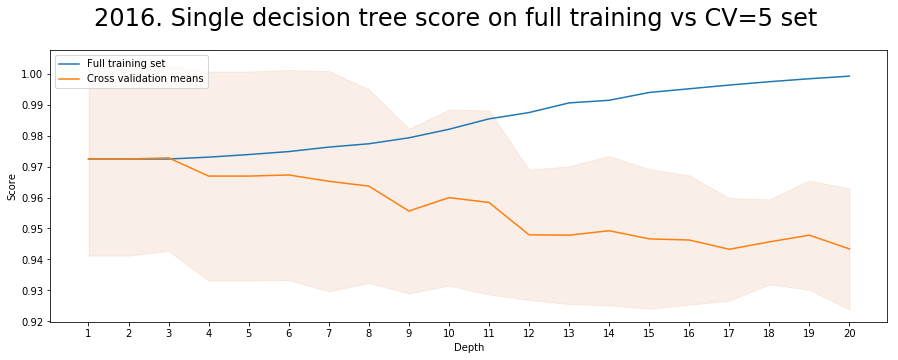

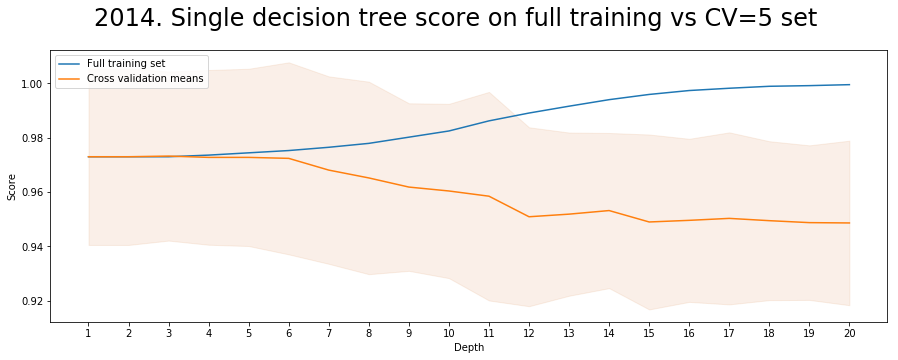

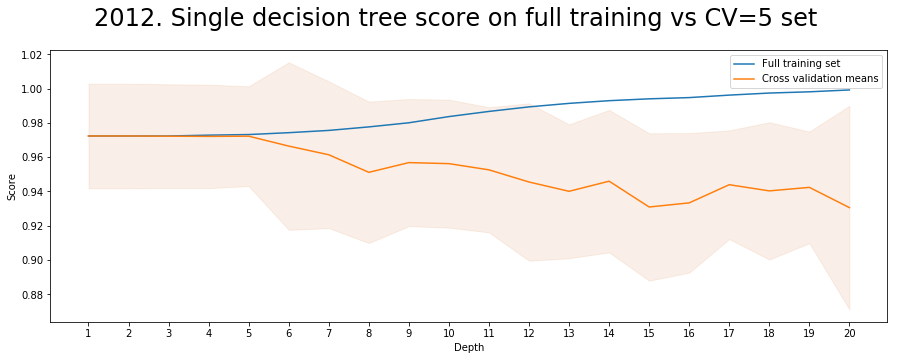

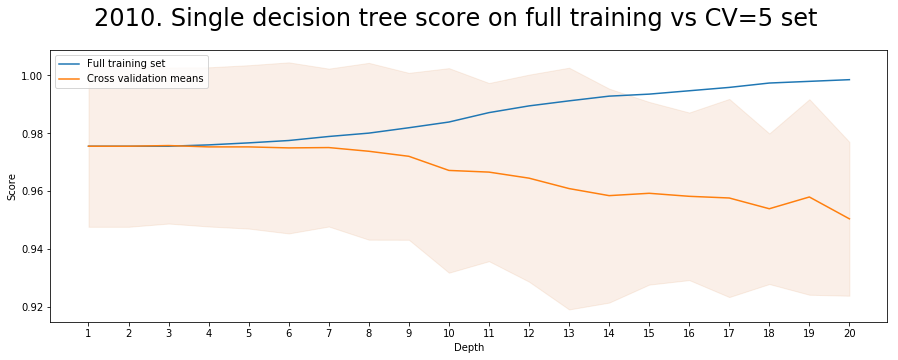

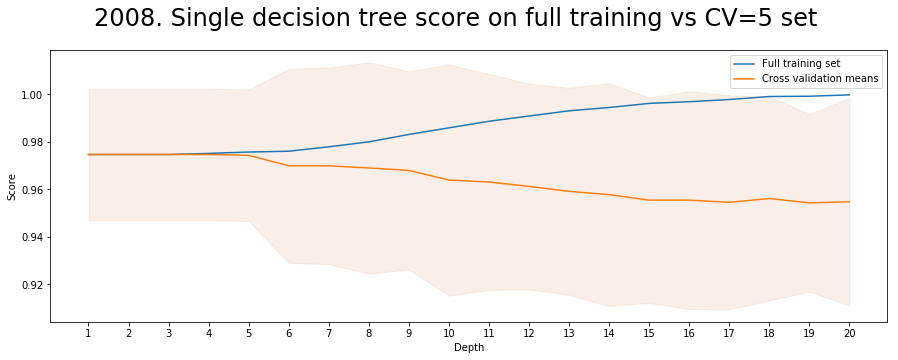

In [201]:
#find best depth for decision tree
#years=Midterm_recent_years
years=All_recent_years[:5]
for year in years:
    #split dataset
    x_train, y_train, x_val, y_val, house_df_districts = splitDf(train_data, year)

    #preprocess
    x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
    x_val_preprocess=preprocess(x_train, y_train, house_df_districts, x_val)

    #remove columns which are not in both datasets, like set(dataset1)^set(dataset2)
    x_train_preprocess=x_train_preprocess[list(x_val_preprocess)]

    #fit model
    depths=list(range(1,21)) #set (maximum) tree depths 1, 2, 3, ..., 20
    scores_train = []
    scores_train_CV = []
    scores_train_CVstd = []
    for depth in depths:
        dt = DecisionTreeClassifier(max_depth = depth)
        scores = cross_val_score(estimator=dt, X=x_train_preprocess, y=y_train, cv=5)
        scores_train_CV.append(scores.mean()) #cross-validated score
        scores_train_CVstd.append(scores.std()) #cross-validated score
        dt.fit(x_train_preprocess, y_train)
        scores_train.append(dt.score(x_train_preprocess, y_train)) #score on training data

    #plot
    title='{}. Single decision tree score on full training vs CV=5 set'.format(year)
    plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title)  

In [205]:
#Add decision tree model
max_depth=4
model=dict()
model['name']='Decision Tree, depth={}'.format(max_depth)
model['model']=DecisionTreeClassifier(max_depth = max_depth)
modelList.append(model)
max_depth=5
model=dict()
model['name']='Decision Tree, depth={}'.format(max_depth)
model['model']=DecisionTreeClassifier(max_depth = max_depth)
modelList.append(model)

In [206]:
modelListTrain(modelList[-2:], train_data, years)

model: Decision Tree, depth=4
year: 2016


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 22 districts have no winner or more than one winner


,state,district,won_pred
8,Arizona,District 1,2.0
36,California,District 24,2.0
58,California,District 44,2.0
60,California,District 46,2.0
85,Delaware,At-Large,2.0
95,Florida,District 18,2.0
96,Florida,District 19,2.0
127,Hawaii,District 1,2.0
157,Indiana,District 9,2.0
175,Louisiana,District 4,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8911,Arizona,District 1,0.0,0.451389,1.0,0.902778,0.5
8916,Arizona,District 1,1.0,0.451389,1.0,0.902778,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
8911,Arizona,District 1,0.0,0.0,2016.0,0.0,0.0,9.0,1.0,1.0,1.0,0.395,1.0,1.0,0.0,0.0,6.234000,0.567816,0.451389
8916,Arizona,District 1,0.0,1.0,2016.0,0.0,0.0,9.0,1.0,1.0,1.0,0.395,1.0,1.0,0.0,0.0,6.367331,0.567816,0.451389


Training accuracy: 85.08%
Validation accuracy: 92.63%
Mutually exclusive validation accuracy: 94.10%
N. Democrat districts: 180
N. Republican districts: 228
Uncertainties: 60

model: Decision Tree, depth=4
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 32 districts have no winner or more than one winner


,state,district,won_pred
17,Arkansas,District 2,2.0
19,Arkansas,District 4,2.0
22,California,District 11,2.0
37,California,District 25,2.0
44,California,District 31,2.0
46,California,District 33,2.0
113,Georgia,District 1,2.0
114,Georgia,District 10,2.0
127,Hawaii,District 1,2.0
158,Iowa,District 1,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.314063,1.0,0.628125,0.5
8120,Arkansas,District 2,1.0,0.314063,1.0,0.628125,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
8114,Arkansas,District 2,0.0,0.0,2014.0,0.0,0.0,6.3,0.0,0.0,0.0,0.48,1.0,1.0,0.0,0.0,6.14041,0.537931,0.314063
8120,Arkansas,District 2,0.0,1.0,2014.0,0.0,0.0,6.3,0.0,0.0,0.0,0.48,1.0,1.0,0.0,0.0,5.92940,0.537931,0.314063


Training accuracy: 85.36%
Validation accuracy: 90.50%
Mutually exclusive validation accuracy: 92.25%
N. Democrat districts: 187
N. Republican districts: 211
Uncertainties: 152

model: Decision Tree, depth=4
year: 2012


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 40 districts have no winner or more than one winner


,state,district,won_pred
8,Arizona,District 1,2.0
15,Arizona,District 9,2.0
19,Arkansas,District 4,2.0
20,California,District 1,2.0
31,California,District 2,2.0
38,California,District 26,2.0
43,California,District 30,2.0
55,California,District 41,2.0
58,California,District 44,2.0
61,California,District 47,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
7303,Arizona,District 1,0.0,0.2506,1.0,0.501199,0.5
7304,Arizona,District 1,1.0,0.2506,1.0,0.501199,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
7303,Arizona,District 1,0.0,0.0,2012.0,4.0,1.0,11.6,1.0,0.0,0.0,0.48,1.0,1.0,0.0,0.0,6.447139,0.556322,0.2506
7304,Arizona,District 1,0.0,1.0,2012.0,0.0,0.0,11.6,1.0,0.0,0.0,0.48,1.0,1.0,0.0,0.0,6.035798,0.556322,0.2506


Training accuracy: 85.63%
Validation accuracy: 86.76%
Mutually exclusive validation accuracy: 89.65%
N. Democrat districts: 169
N. Republican districts: 221
Uncertainties: 160

model: Decision Tree, depth=4
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 20 districts have no winner or more than one winner


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
87,Florida,District 12,2.0
134,Indiana,District 8,2.0
140,Kansas,District 1,2.0
142,Kansas,District 3,2.0
143,Kansas,District 4,2.0
152,Louisiana,District 3,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.205037,1.0,0.410074,0.5
6570,Alabama,District 5,0.0,0.205037,1.0,0.410074,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
6569,Alabama,District 5,0.0,1.0,2010.0,0.0,0.0,9.4,0.0,1.0,0.0,0.48,0.0,1.0,0.0,0.0,5.921221,0.409195,0.205037
6570,Alabama,District 5,0.0,0.0,2010.0,0.0,0.0,9.4,0.0,1.0,0.0,0.48,0.0,1.0,0.0,0.0,5.961540,0.409195,0.205037


Training accuracy: 86.10%
Validation accuracy: 81.63%
Mutually exclusive validation accuracy: 82.95%
N. Democrat districts: 149
N. Republican districts: 106
Uncertainties: 59

model: Decision Tree, depth=4
year: 2008


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 21 districts have no winner or more than one winner


,state,district,won_pred
1,Alabama,District 2,2.0
4,Alabama,District 5,2.0
8,Arizona,District 1,2.0
65,California,District 52,2.0
72,Colorado,District 2,2.0
76,Colorado,District 6,2.0
89,Florida,District 15,2.0
153,Louisiana,District 4,2.0
155,Louisiana,District 6,2.0
158,Maryland,District 1,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5778,Alabama,District 2,1.0,0.218723,1.0,0.437446,0.5
5779,Alabama,District 2,0.0,0.218723,1.0,0.437446,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
5778,Alabama,District 2,0.0,1.0,2008.0,0.0,0.0,6.5,1.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,5.914881,0.464368,0.218723
5779,Alabama,District 2,0.0,0.0,2008.0,0.0,0.0,6.5,1.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,5.914881,0.464368,0.218723


Training accuracy: 85.85%
Validation accuracy: 87.02%
Mutually exclusive validation accuracy: 88.44%
N. Democrat districts: 138
N. Republican districts: 106
Uncertainties: 6

model: Decision Tree, depth=5
year: 2016


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 14 districts have no winner or more than one winner


,state,district,won_pred
8,Arizona,District 1,2.0
36,California,District 24,2.0
58,California,District 44,2.0
60,California,District 46,2.0
85,Delaware,At-Large,2.0
96,Florida,District 19,2.0
187,Maryland,District 8,2.0
197,Michigan,District 1,2.0
236,Nevada,District 3,2.0
328,Pennsylvania,District 16,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8911,Arizona,District 1,0.0,0.425373,1.0,0.850746,0.5
8916,Arizona,District 1,1.0,0.425373,1.0,0.850746,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
8911,Arizona,District 1,0.0,0.0,2016.0,0.0,0.0,9.0,1.0,1.0,1.0,0.395,1.0,1.0,0.0,0.0,6.234000,0.567816,0.425373
8916,Arizona,District 1,0.0,1.0,2016.0,0.0,0.0,9.0,1.0,1.0,1.0,0.395,1.0,1.0,0.0,0.0,6.367331,0.567816,0.425373


Training accuracy: 85.52%
Validation accuracy: 92.51%
Mutually exclusive validation accuracy: 91.89%
N. Democrat districts: 182
N. Republican districts: 234
Uncertainties: 311

model: Decision Tree, depth=5
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 23 districts have no winner or more than one winner


,state,district,won_pred
17,Arkansas,District 2,2.0
19,Arkansas,District 4,2.0
46,California,District 33,2.0
113,Georgia,District 1,2.0
114,Georgia,District 10,2.0
127,Hawaii,District 1,2.0
158,Iowa,District 1,2.0
160,Iowa,District 3,2.0
176,Louisiana,District 5,2.0
179,Maine,District 2,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.420925,1.0,0.841849,0.5
8120,Arkansas,District 2,1.0,0.420925,1.0,0.841849,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
8114,Arkansas,District 2,0.0,0.0,2014.0,0.0,0.0,6.3,0.0,0.0,0.0,0.48,1.0,1.0,0.0,0.0,6.14041,0.537931,0.420925
8120,Arkansas,District 2,0.0,1.0,2014.0,0.0,0.0,6.3,0.0,0.0,0.0,0.48,1.0,1.0,0.0,0.0,5.92940,0.537931,0.420925


Training accuracy: 85.61%
Validation accuracy: 90.50%
Mutually exclusive validation accuracy: 92.88%
N. Democrat districts: 189
N. Republican districts: 218
Uncertainties: 96

model: Decision Tree, depth=5
year: 2012


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 40 districts have no winner or more than one winner


,state,district,won_pred
8,Arizona,District 1,2.0
15,Arizona,District 9,2.0
19,Arkansas,District 4,2.0
20,California,District 1,2.0
31,California,District 2,2.0
38,California,District 26,2.0
43,California,District 30,2.0
55,California,District 41,2.0
58,California,District 44,2.0
61,California,District 47,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
7303,Arizona,District 1,0.0,0.224,1.0,0.448,0.5
7304,Arizona,District 1,1.0,0.224,1.0,0.448,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
7303,Arizona,District 1,0.0,0.0,2012.0,4.0,1.0,11.6,1.0,0.0,0.0,0.48,1.0,1.0,0.0,0.0,6.447139,0.556322,0.224
7304,Arizona,District 1,0.0,1.0,2012.0,0.0,0.0,11.6,1.0,0.0,0.0,0.48,1.0,1.0,0.0,0.0,6.035798,0.556322,0.224


Training accuracy: 85.98%
Validation accuracy: 86.76%
Mutually exclusive validation accuracy: 89.65%
N. Democrat districts: 169
N. Republican districts: 221
Uncertainties: 118

model: Decision Tree, depth=5
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 20 districts have no winner or more than one winner


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
87,Florida,District 12,2.0
134,Indiana,District 8,2.0
140,Kansas,District 1,2.0
142,Kansas,District 3,2.0
143,Kansas,District 4,2.0
152,Louisiana,District 3,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.16045,1.0,0.320901,0.5
6570,Alabama,District 5,0.0,0.16045,1.0,0.320901,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
6569,Alabama,District 5,0.0,1.0,2010.0,0.0,0.0,9.4,0.0,1.0,0.0,0.48,0.0,1.0,0.0,0.0,5.921221,0.409195,0.16045
6570,Alabama,District 5,0.0,0.0,2010.0,0.0,0.0,9.4,0.0,1.0,0.0,0.48,0.0,1.0,0.0,0.0,5.961540,0.409195,0.16045


Training accuracy: 86.46%
Validation accuracy: 79.36%
Mutually exclusive validation accuracy: 83.71%
N. Democrat districts: 151
N. Republican districts: 104
Uncertainties: 38

model: Decision Tree, depth=5
year: 2008


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: 21 districts have no winner or more than one winner


,state,district,won_pred
1,Alabama,District 2,2.0
4,Alabama,District 5,2.0
8,Arizona,District 1,2.0
65,California,District 52,2.0
72,Colorado,District 2,2.0
76,Colorado,District 6,2.0
89,Florida,District 15,2.0
153,Louisiana,District 4,2.0
155,Louisiana,District 6,2.0
158,Maryland,District 1,2.0


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5778,Alabama,District 2,1.0,0.262805,1.0,0.52561,0.5
5779,Alabama,District 2,0.0,0.262805,1.0,0.52561,0.5


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_house_majority,partisanship_1,partisanship_2,partisanship_3,Log10fundraising,last_R_vs_D_Seats,abs_won_proba
5778,Alabama,District 2,0.0,1.0,2008.0,0.0,0.0,6.5,1.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,5.914881,0.464368,0.262805
5779,Alabama,District 2,0.0,0.0,2008.0,0.0,0.0,6.5,1.0,1.0,0.0,0.48,0.0,0.0,0.0,1.0,5.914881,0.464368,0.262805


Training accuracy: 86.04%
Validation accuracy: 88.44%
Mutually exclusive validation accuracy: 88.84%
N. Democrat districts: 139
N. Republican districts: 105
Uncertainties: 195



[{'name': 'Decision Tree, depth=4',
  'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'),
  'score train': 0.8560525393588074,
  'score validation': 0.8770779446145877,
  'score val mut exclusive': 0.8947937925919962,
  'N. uncertainties': 87.4},
 {'name': 'Decision Tree, depth=5',
  'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'),
  'score train': 0.85923432693913

In [260]:
def plotScores(models_names, scores_train, scores_val, scores_val_mut_escl, baseline_accuracy):
    #plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle('Scores of all fitted models on training vs validation set', fontsize=24, y=1)
    ax.barh(models_names, scores_train, alpha=0.5, label='train set') 
    ax.barh(models_names, scores_val, alpha=0.5, label='val set')   
    ax.barh(models_names, scores_val_mut_escl, alpha=0.5, label='val set mut. excl.')  
    max_scores=np.maximum(np.maximum(np.array(scores_train),np.array(scores_val)),np.array(scores_val_mut_escl))
    for i, v in enumerate(max_scores):
        ax.text(v+0.005, i, '{:<.2%}'.format(v), color='black', fontsize=12)
        #ax.text(scores_val[i]+0.015, i, '{:.4}'.format(v), color='royalblue', fontsize=12)
    min_scores=np.minimum(np.minimum(np.array(scores_train),np.array(scores_val)),np.array(scores_val_mut_escl))
    for i, v in enumerate(min_scores):
        ax.text(v-0.03, i, '{:>.2%}'.format(v), color='white', fontsize=12)    
    ax.axvline(x=baseline_accuracy, c='g', label='baseline')
    #ax.text(baseline_accuracy, 0, '{:.2%}'.format(baseline_accuracy), color='green', horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax.set_xlabel('Score')
    plt.xlim(baseline_accuracy*0.95,1)
    fig.legend(bbox_to_anchor=(1.25, 0.88));
def plotModelsScores(modelList, baseline_accuracy):
    models_names=[]
    scores_train=[] 
    scores_val=[] 
    scores_val_mut_escl=[]
    for model in modelList:
        models_names.append(model['name'])
        scores_train.append(model['score train'])
        scores_val.append(model['score validation'])
        scores_val_mut_escl.append(model['score val mut exclusive'])
    plotScores(models_names, scores_train, scores_val, scores_val_mut_escl, baseline_accuracy)

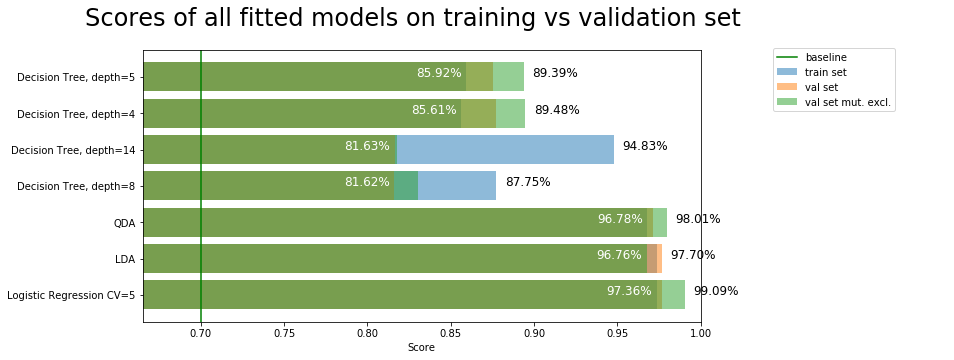

In [261]:
baseline_accuracy=0.7 #TO BE UPDATED
plotModelsScores(modelList, baseline_accuracy)

In [202]:
#house_df[(house_df['state']=='Louisiana')&(house_df['district']=='District 3')&(house_df['year']==2018)]
#house_df[(house_df['state']=='California')&(house_df['district']=='District 17')&(house_df['year']==2014)]
house_df[(house_df['state']=='Colorado')&(house_df['district']=='District 3')&(house_df['year']==2014)]
#house_df.iloc[[9600, 9801, 9813, 9904], :] #9600, 9801, 9813, 9904

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
8016,District 3,0.0,Abel Tapia,D,35.7,Colorado,100364,0,2014,0.0,0,6.7,0.0,0.0,D,0.48,201.0,234.0,R,279186.35
8018,District 3,1.0,Scott Tipton,R,58.0,Colorado,163011,1,2014,2010.0,2,6.7,0.0,0.0,D,0.48,201.0,234.0,R,1284602.01


In [108]:
(house_df[(house_df['year']==1998)]).head()

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
3705,District 2,1.0,James M. Talent,R,70.00,Missouri,142313,1,1998,1998.0,0,4.5,0.0,0.0,D,0.551,206.0,228.0,R,1.449403e+06
3706,District 21,1.0,Michael R. McNulty,D,74.20,New York,146729,1,1998,1996.0,1,4.5,0.0,0.0,D,0.551,206.0,228.0,R,1.670470e+06
3707,District 21,0.0,John Evans,D,21.09,California,30994,0,1998,0.0,0,4.5,0.0,0.0,D,0.551,206.0,228.0,R,1.600282e+06
3708,District 15,1.0,Rubén Hinojosa,D,58.35,Texas,47957,1,1998,1998.0,0,4.5,0.0,0.0,D,0.551,206.0,228.0,R,5.335589e+05
3709,District 2,0.0,John Ross,D,28.30,Missouri,57565,0,1998,0.0,0,4.5,0.0,0.0,D,0.551,206.0,228.0,R,1.449403e+06


(array([380.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 460.]),
 array([3.30403100e-05, 9.62975392e-02, 1.92562038e-01, 2.88826537e-01,
        3.85091036e-01, 4.81355535e-01, 5.77620034e-01, 6.73884533e-01,
        7.70149032e-01, 8.66413531e-01, 9.62678029e-01]),
 <a list of 10 Patch objects>)

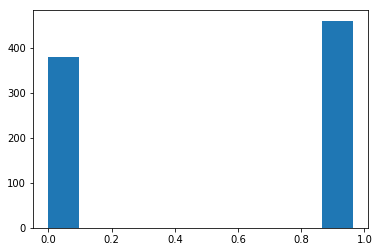

In [194]:
plt.hist(pred_df['abs_won_proba'])

(array([380.,   0.,   0.,   0.,  25.,  25.,   0.,   0.,   0., 410.]),
 array([3.48746356e-05, 1.00031387e-01, 2.00027900e-01, 3.00024412e-01,
        4.00020925e-01, 5.00017437e-01, 6.00013950e-01, 7.00010462e-01,
        8.00006975e-01, 9.00003487e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

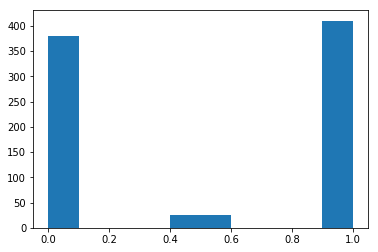

In [195]:
plt.hist(pred_df['rel_won_proba'])